In [1]:
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import pandas as pd
import xarray as xr
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff
import os

sys.path.append('../10_Scripts')
import SpatialTools
import gdal
import DEADataHandling
import DEAPlotting
dc = datacube.Datacube(app='Snow monitoring with Landsat')

In [6]:
# lat, lon, buffer_m, buffer_n = -36.3, 148.35, 30000, 40000
lat, lon, buffer_m, buffer_n = -41.56728, 147.67106, 10000, 10000 #tas ben lomond
time_range = ('2018-08-01', '2018-08-28')
resolution = (-25, 25)
landsat_goodquality_prop = 0.70
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

In [7]:
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, 
                                               product = 'nbar',
                                               query=query,
                                               sensors=['ls5','ls7','ls8'],
                                               bands_of_interest=['red', 'green', 'blue','nir', 'swir1'],
                                               masked_prop=landsat_goodquality_prop,
                                               mask_pixel_quality=False,
                                               ls7_slc_off=True)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Loading 0 filtered ls7 timesteps
Loading ls8
    Loading 1 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [8]:
elevation_query = {'x': (x - buffer_m, x + buffer_m),
         'y': (y - buffer_n, y + buffer_n),    
         #'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 
elevation_data = dc.load(product='srtm_dem1sv1_0', **elevation_query)
# elevation_data.dem.plot(figsize=(8,10),cmap='terrain')
elevation_2d = elevation_data.dem_h.squeeze('time')

In [9]:
# contour_gdf_1800 = SpatialTools.contour_extract(z_values=1800,
#                                             ds_array=elevation_2d,
#                                             ds_crs=elevation_2d.geobox.crs,
#                                             ds_affine=elevation_2d.geobox.affine,
#                                             output_shp='extracted_contours_1800.shp')
contour_gdf_1500 = SpatialTools.contour_extract(z_values=1500,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_tas_contours_1500.shp')
contour_gdf_1200 = SpatialTools.contour_extract(z_values=1200,
                                            ds_array=elevation_2d,
                                            ds_crs=elevation_2d.geobox.crs,
                                            ds_affine=elevation_2d.geobox.affine,
                                            output_shp='extracted_tas_contours_1200.shp')

Operating in single array, multiple z-values mode
    Extracting contour 1500
Exporting contour shapefile to extracted_tas_contours_1500.shp
Operating in single array, multiple z-values mode
    Extracting contour 1200
Exporting contour shapefile to extracted_tas_contours_1200.shp


In [27]:
Snow_phen1200_2015_2018=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/phen/2015_2018_phenology_freq_1200.csv')
# '/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/1987_1989__frequency_prop.csv' 
Snow_phen1200_2010_2014=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/phen/2010_2014_phenology_freq_1200.csv')
Snow_phen1200_2005_2009=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/phen/2005_2009_phenology_freq_1200.csv')
Snow_phen1200_2000_2004=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/phen/2000_2004_phenology_freq_1200.csv')
Snow_phen1200_2010_2018=pd.concat([Snow_phen1200_2010_2014, Snow_phen1200_2015_2018])
Snow_phen1200_2000_2009=pd.concat([Snow_phen1200_2000_2004, Snow_phen1200_2005_2009])

Snow_phen1200_1995_1999=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/phen/1995_1999_phenology_freq_1200.csv')
Snow_phen1200_1990_1994=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/phen/1990_1994_phenology_freq_1200.csv')
Snow_phen1200_1987_1989=pd.read_csv('/g/data/r78/jt7365/dea-notebooks/SnowOFS/results/Tas/1200/phen/1987_1989_phenology_freq_1200.csv')
Snow_phen1200_1990_1999=pd.concat([Snow_phen1200_1990_1994, Snow_phen1200_1995_1999])
Snow_phen1200_1987_1989=pd.concat([Snow_phen1200_1987_1989])


Snow_phen1200=pd.concat([Snow_phen1200_2000_2009, Snow_phen1200_2010_2018])
Snow_phen1200_10s=pd.concat([Snow_phen1200_2010_2018])
Snow_phen1200_00s=pd.concat([Snow_phen1200_2000_2009])
Snow_phen1200_90s=pd.concat([Snow_phen1200_1990_1999])
Snow_phen1200_80s=Snow_phen1200_1987_1989

In [26]:
# Snow_phen1200_2015_2018

In [16]:
#1800
# Snow_phen2016_2018=pd.read_csv('results/threshold_02/phenology_freq/1800/2016_2018_phenology_freq_1800.csv')
# Snow_phen2014_2015=pd.read_csv('results/threshold_02/phenology_freq/1800/2014_2015_phenology_freq_1800.csv')
# Snow_phen2012_2013=pd.read_csv('results/threshold_02/phenology_freq/1800/2012_2013_phenology_freq_1800.csv')
# Snow_phen2010_2011=pd.read_csv('results/threshold_02/phenology_freq/1800/2010_2011_phenology_freq_1800.csv')
# Snow_phen2008_2009=pd.read_csv('results/threshold_02/phenology_freq/1800/2008_2009_phenology_freq_1800.csv')
# Snow_phen2006_2007=pd.read_csv('results/threshold_02/phenology_freq/1800/2006_2007_phenology_freq_1800.csv')
# Snow_phen2004_2005=pd.read_csv('results/threshold_02/phenology_freq/1800/2004_2005_phenology_freq_1800.csv')
# Snow_phen2002_2003=pd.read_csv('results/threshold_02/phenology_freq/1800/2002_2003_phenology_freq_1800.csv')
# Snow_phen2000_2001=pd.read_csv('results/threshold_02/phenology_freq/1800/2000_2001_phenology_freq_1800.csv')
# Snow_phen1998_1999=pd.read_csv('results/threshold_02/phenology_freq/1800/1998_1999_phenology_freq_1800.csv')
# Snow_phen1996_1997=pd.read_csv('results/threshold_02/phenology_freq/1800/1996_1997_phenology_freq_1800.csv')
# Snow_phen1994_1995=pd.read_csv('results/threshold_02/phenology_freq/1800/1994_1995_phenology_freq_1800.csv')
# Snow_phen1992_1993=pd.read_csv('results/threshold_02/phenology_freq/1800/1992_1993_phenology_freq_1800.csv')
# Snow_phen1990_1991=pd.read_csv('results/threshold_02/phenology_freq/1800/1990_1991_phenology_freq_1800.csv')
# Snow_phen1987_1989=pd.read_csv('results/threshold_02/phenology_freq/1800/1987_1989_phenology_freq_1800.csv')


# Snow_phen1800=pd.concat([Snow_phen1987_1989, Snow_phen1990_1991, Snow_phen1992_1993, Snow_phen1994_1995, Snow_phen1996_1997, Snow_phen1998_1999, Snow_phen2000_2001,
#                              Snow_phen2002_2003, Snow_phen2004_2005, 
#                          Snow_phen2006_2007, 
#                          Snow_phen2008_2009, Snow_phen2010_2011, Snow_phen2012_2013, Snow_phen2014_2015, Snow_phen2016_2018])

# Snow_phen1800_10s=pd.concat([Snow_phen2010_2011, Snow_phen2012_2013, Snow_phen2014_2015, Snow_phen2016_2018])
# Snow_phen1800_00s=pd.concat([Snow_phen2000_2001, Snow_phen2002_2003, Snow_phen2004_2005, Snow_phen2006_2007, Snow_phen2008_2009])
# Snow_phen1800_90s=pd.concat([Snow_phen1990_1991, Snow_phen1992_1993, Snow_phen1994_1995, Snow_phen1996_1997, Snow_phen1998_1999])
# Snow_phen1800_80s=Snow_phen1987_1989

In [11]:
Snow_phen1800_10s.keys()

Index(['Unnamed: 0', 'dayofyear', 'snow_prop_elev', 'year'], dtype='object')

In [28]:
snow_phen1200=[(Snow_phen1200_10s,2010),
           (Snow_phen1200_00s, 2000), 
           (Snow_phen1200_90s, 1990),
           (Snow_phen1200_80s, 1980)
          ]

# snow_phen1500=[(Snow_phen1500_10s,2010),
#            (Snow_phen1500_00s, 2000), 
#            (Snow_phen1500_90s, 1990),
#            (Snow_phen1500_80s, 1980)
#           ]

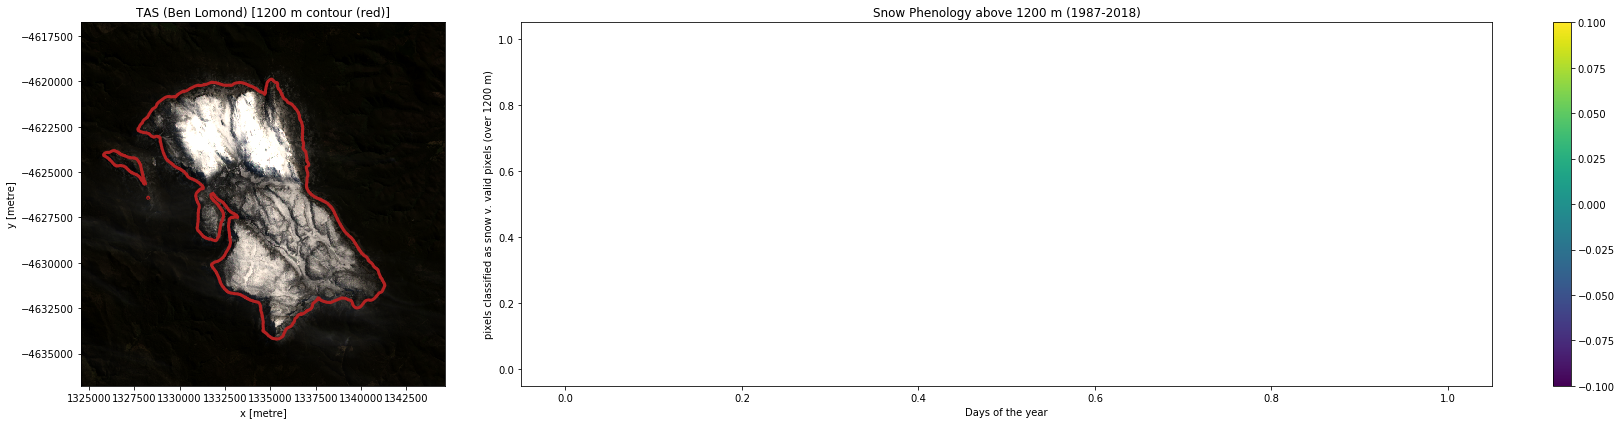

In [23]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_TAS_dem_snowf_v.pdf")

dfs=[(Snow_phen1200, 1200)] 
#      (Snow_phen1500, 1500, 0, 3, 'orange')
for i, j in dfs:
    fig, axes = plt.subplots(ncols=2, 
                             figsize = (25, 6),
                            gridspec_kw={'width_ratios': [2, 5]})
    # valid_ds.isel(time=60).plot(cmap='Reds_r', ax=axes[0]) #85
    # valid_ds1.isel(time=38).plot(cmap='Reds_r', ax=axes[1]) #85




    a=landsat_ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
#     a=contour_gdf_1500.plot(ax=axes[0], linewidth=l, color='orange')
    a=contour_gdf_1200.plot(ax=axes[0], linewidth=3, color='firebrick')
    a.title.set_text('TAS (Ben Lomond) ['+str(j)+' m contour (red)]')
    plt.tight_layout()

    sp = plt.scatter(i['dayofyear'], #ndsi_ds.values, 
                    i['snow_prop_elev'], c=i['year'],
                    cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
    plt.title('Snow Phenology above '+str(j)+' m (1987-2018)')
    plt.xlabel('Days of the year')
    plt.ylabel('pixels classified as snow v. valid pixels (over '+str(j)+' m)')
    fig.colorbar(sp)
    pdf.savefig()
pdf.close()

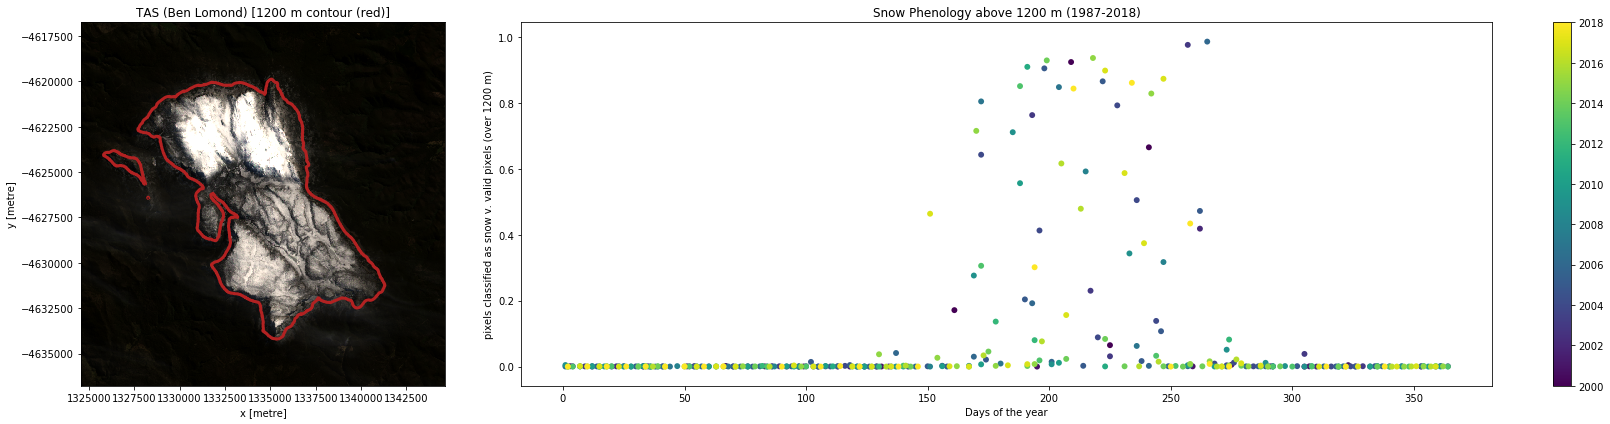

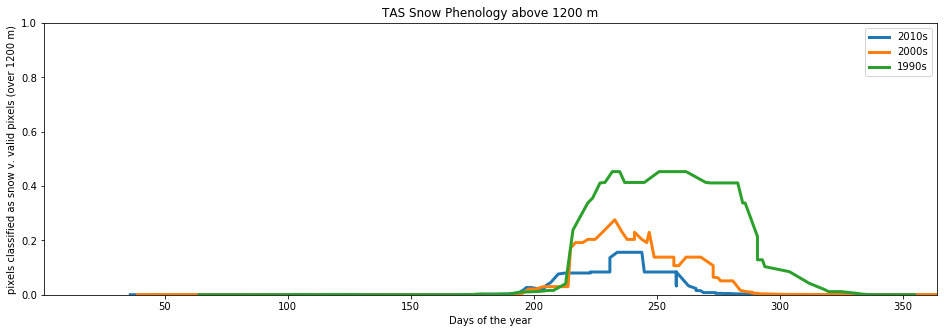

In [32]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_TAS_dem_snowf_v.pdf")

dfs=[
#     (Snow_phen1500, 1500, 3, 0, 'orange'), 
    (Snow_phen1200, 1200, 0, 3, 'red')
    ]
for i, j, k, l, m in dfs:
    fig, axes = plt.subplots(ncols=2, 
                             figsize = (25, 6),
                            gridspec_kw={'width_ratios': [2, 5]})

    a=landsat_ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(ax=axes[0],robust=True)
#     a=contour_gdf_1800.plot(ax=axes[0], linewidth=k, color='mediumblue')
#     a=contour_gdf_1500.plot(ax=axes[0], linewidth=k, color='orange')
    a=contour_gdf_1200.plot(ax=axes[0], linewidth=l, color='firebrick')
    a.title.set_text('TAS (Ben Lomond) ['+str(j)+' m contour ('+str(m)+')]')
    plt.tight_layout()

    sp = plt.scatter(i['dayofyear'], #ndsi_ds.values, 
                    i['snow_prop_elev'], c=i['year'],
                    cmap='viridis', marker='o', edgecolor='none',s=35)
#     plt.ylim(0,2)
    plt.title('Snow Phenology above '+str(j)+' m (1987-2018)')
    plt.xlabel('Days of the year')
    plt.ylabel('pixels classified as snow v. valid pixels (over '+str(j)+' m)')
    fig.colorbar(sp)
    pdf.savefig()
    
# fig, ax = plt.subplots(figsize=(16,5))   
# a=Snow_phen1500_10s.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)

# a=Snow_phen1500_00s.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)

# a=Snow_phen1500_90s.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# b.rolling(25).median().plot(y='snow_prop_elev',ax=ax, linewidth=3)

# plt.title('VIC Snow Phenology above 1500 m')
# plt.xlabel('Days of the year')
# plt.ylabel('pixels classified as snow v. valid pixels (over 1500 m)')
# plt.legend(['2010s', '2000s', '1990s'])
# pdf.savefig()

fig, ax = plt.subplots(figsize=(16,5))
a=Snow_phen1200_10s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)

a=Snow_phen1200_00s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)

a=Snow_phen1200_90s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)
plt.ylim(0,1)
plt.title('TAS Snow Phenology above 1200 m')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1200 m)')
plt.legend(['2010s', '2000s', '1990s'])
# fig.colorbar(sp)
pdf.savefig()
pdf.close()

In [13]:
a=Snow_phen1800_10s.set_index('dayofyear')
b=a.sort_index(ascending=True)
# Snow_phen1800_10s
# b

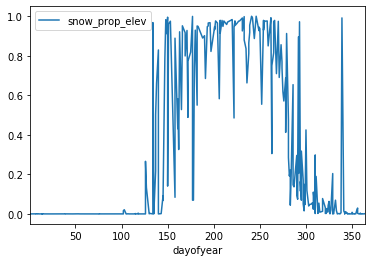

In [174]:
b.plot(y='snow_prop_elev')

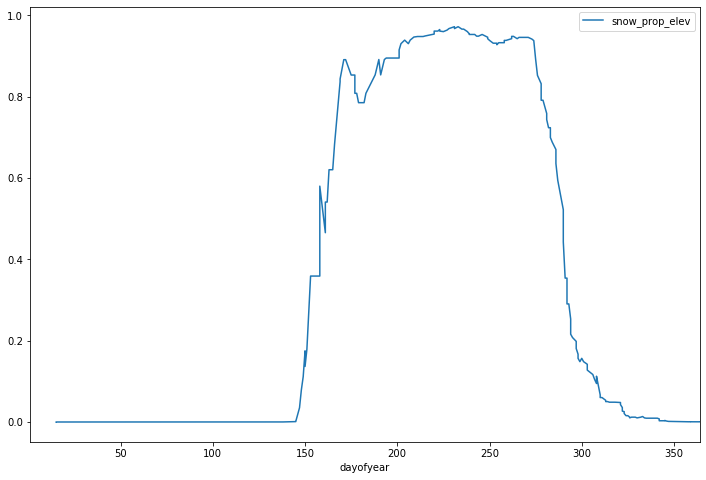

In [183]:
b.rolling(20).median().plot(y='snow_prop_elev',figsize=(12, 8))

In [14]:
# # print(Snow_phen1800_10s.groupby('dayofyear').groups)
# b=Snow_phen1800_10s.groupby('dayofyear')
# # a.mean('snow_prop_elev')
# # print(b.get_group(102))
# mean = b['snow_prop_elev'].agg(np.mean)


In [15]:
# mean=b['snow_prop_elev'].agg(np.mean)

In [1]:
# list(mean)

In [16]:
# Snow_phen1800_10s['mean'] = mean

In [17]:
# Snow_phen1800_10s.loc[:,'mean'][200:202]

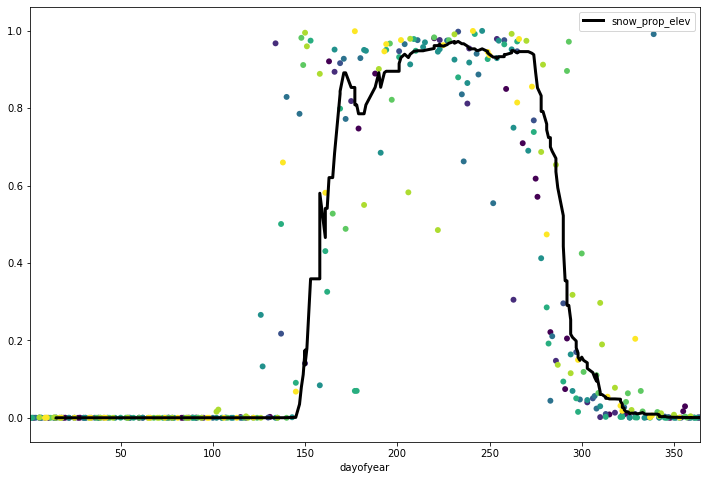

In [18]:
fig, ax = plt.subplots(figsize=(20,5))
# #     pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW.pdf")
sp = ax.scatter(Snow_phen1800_10s['dayofyear'], #ndsi_ds.values, 
                Snow_phen1800_10s['snow_prop_elev'], c=Snow_phen1800_10s['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
b.rolling(20).median().plot(y='snow_prop_elev',figsize=(12, 8), ax=ax, color='black', linewidth=3)
# mean = ax.scatter(Snow_phen1800_10s['dayofyear'], #ndsi_ds.values, 
#                 Snow_phen1800_10s['mean'], #c=Snow_phen1800_10s['year'],
# #                 cmap='viridis', 
#                   color='red',
#                   marker='s', edgecolor='none',s=35)

In [2]:
# z = np.polyfit(x=Snow_phen1800_10s.loc[:, 'dayofyear'], y=Snow_phen1800_10s.loc[:, 'snow_prop_elev'], deg=2)
# p = np.poly1d(z)
# Snow_phen1800_10s['trendline'] = p(Snow_phen1800_10s.loc[:, 'dayofyear'])

# # ax = Snow_phen1800_10s.plot.scatter(x='dayofyear', y='snow_prop_elev')
# Snow_phen1800_10s.set_index('dayofyear', inplace=True)
# Snow_phen1800_10s.sort_index(ascending=True)
# Snow_phen1800_10s.trendline.plot()
fig, ax = plt.subplots(figsize=(20,5))
# #     pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW.pdf")
sp = ax.scatter(Snow_phen1800_10s.index, #ndsi_ds.values, 
                Snow_phen1800_10s['snow_prop_elev'], c=Snow_phen1800_10s['year'],
                cmap='viridis', marker='o', edgecolor='none',s=35)
# Snow_phen1800_10s['trendline'].plot(ax=ax)      
# # #plt.ylim(-1, 1)
# plt.title('2010s Snow Phenology above 1800 m')
# # plt.xlabel('Days of the year')
# # plt.ylabel('pixels classified as snow v. valid pixels (over '+str(j)+' m)')
# # fig.colorbar(sp)


NameError: name 'plt' is not defined

In [3]:
# Snow_phen1800_10s

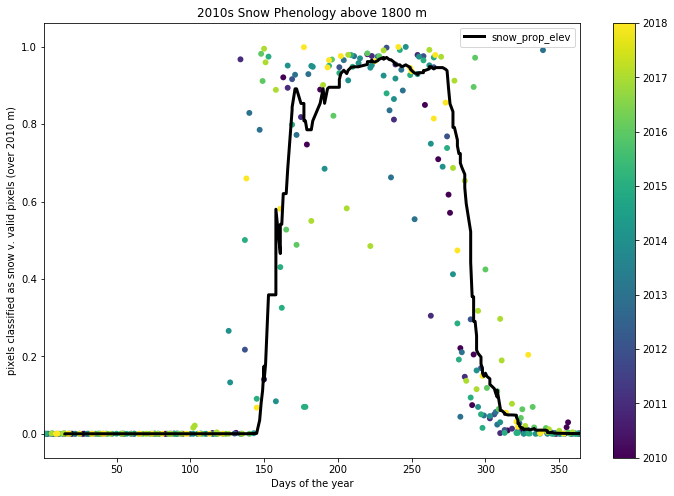

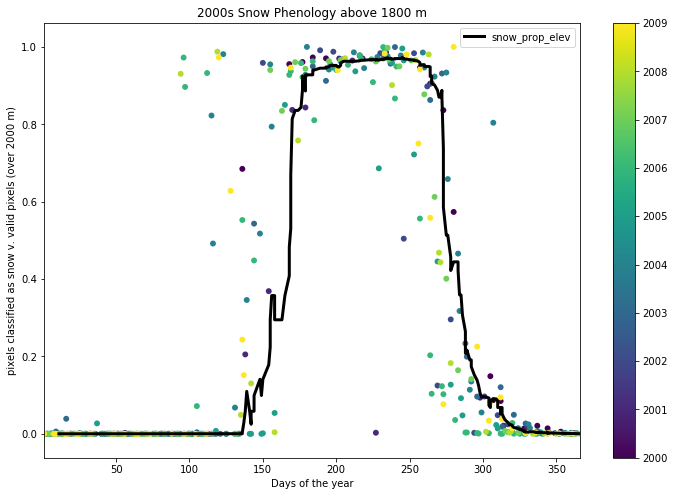

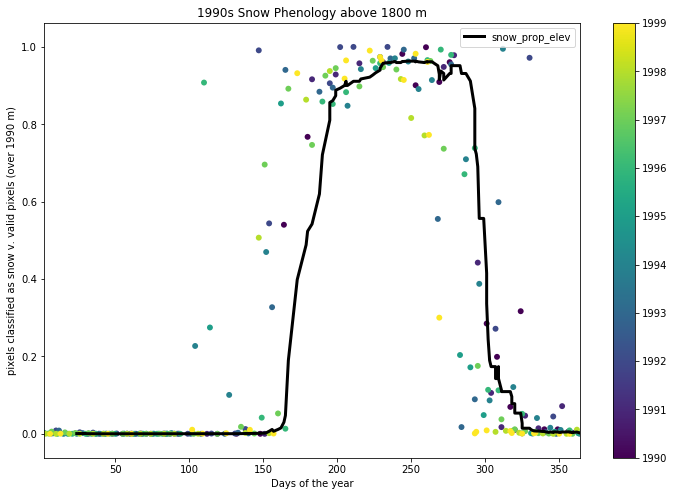

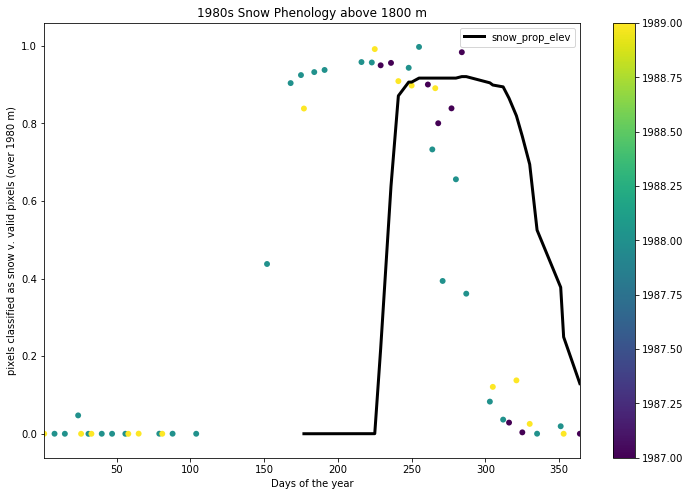

In [23]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW_decades.pdf")
# a=Snow_phen1800_10s.set_index('dayofyear')
# b=a.sort_index(ascending=True)

for i, j in snow_phen1800:
    a=i.set_index('dayofyear')
    b=a.sort_index(ascending=True)
    fig, ax = plt.subplots(figsize=(16,5))
#     pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW.pdf")
    sp = ax.scatter(i['dayofyear'], #ndsi_ds.values, 
                    i['snow_prop_elev'], c=i['year'],
                    cmap='viridis', marker='o', edgecolor='none',s=35)
    b.rolling(20).median().plot(y='snow_prop_elev',figsize=(12, 8), ax=ax, color='black', linewidth=3)
    
    #plt.ylim(-1, 1)
    plt.title(str(j)+'s Snow Phenology above 1800 m')
    plt.xlabel('Days of the year')
    plt.ylabel('pixels classified as snow v. valid pixels (over '+str(j)+' m)')
    fig.colorbar(sp)
#     pdf.savefig()
# pdf.close()

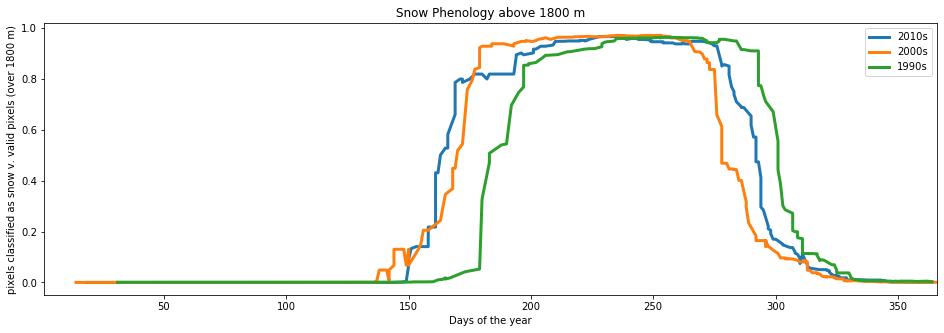

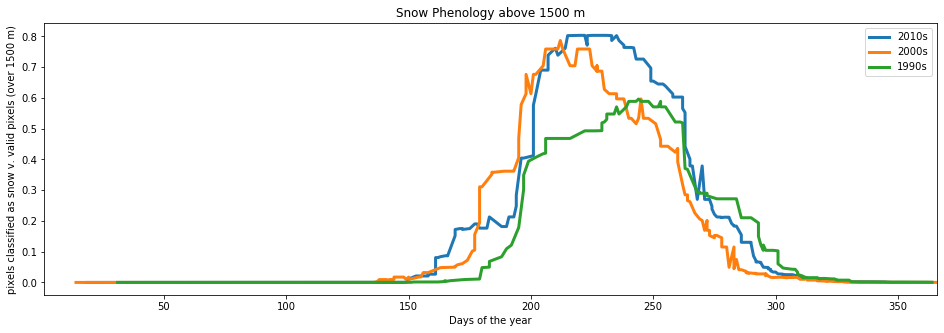

In [46]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW_decades.pdf")
# a=Snow_phen1800_10s.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# Snow_phen1800

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

snow_phen1800=[(Snow_phen1800_10s,2010),
           (Snow_phen1800_00s, 2000), 
           (Snow_phen1800_90s, 1990),
           (Snow_phen1800_80s, 1980)
          ]

pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW_mean.pdf")
fig, ax = plt.subplots(figsize=(16,5))
a=Snow_phen1800_10s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', 
#                             color='blue',
                            ax=ax, linewidth=3)

a=Snow_phen1800_00s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', 
#                             color='orange',
                            ax=ax, linewidth=3)

a=Snow_phen1800_90s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev',
#                             color='green', 
                            ax=ax, linewidth=3)

plt.title('Snow Phenology above 1800 m')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1800 m)')
plt.legend(['2010s', '2000s', '1990s'])
pdf.savefig()
fig, ax = plt.subplots(figsize=(16,5))
a=Snow_phen1500_10s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)

a=Snow_phen1500_00s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)

a=Snow_phen1500_90s.set_index('dayofyear')
b=a.sort_index(ascending=True)
b.rolling(25).median().plot(y='snow_prop_elev', ax=ax, linewidth=3)





# # for i, j in snow_phen1800:
# a=.set_index('dayofyear')
# b=a.sort_index(ascending=True)
# fig, ax = plt.subplots(figsize=(16,5))
# #     pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW.pdf")
# sp = ax.scatter(i['dayofyear'], #ndsi_ds.values, 
#                 i['snow_prop_elev'], c=i['year'],
#                 cmap='viridis', marker='o', edgecolor='none',s=35)
# b.rolling(20).median().plot(y='snow_prop_elev',figsize=(12, 8), ax=ax, color='black', linewidth=3)

# #plt.ylim(-1, 1)
plt.title('Snow Phenology above 1500 m')
plt.xlabel('Days of the year')
plt.ylabel('pixels classified as snow v. valid pixels (over 1500 m)')
plt.legend(['2010s', '2000s', '1990s'])
# fig.colorbar(sp)
pdf.savefig()
pdf.close()

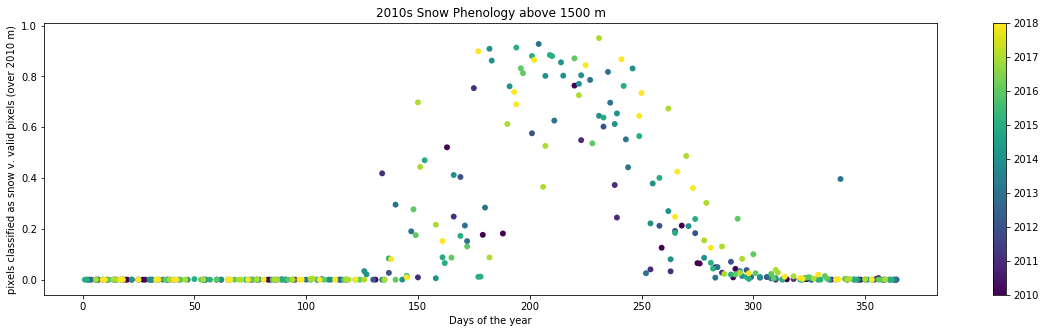

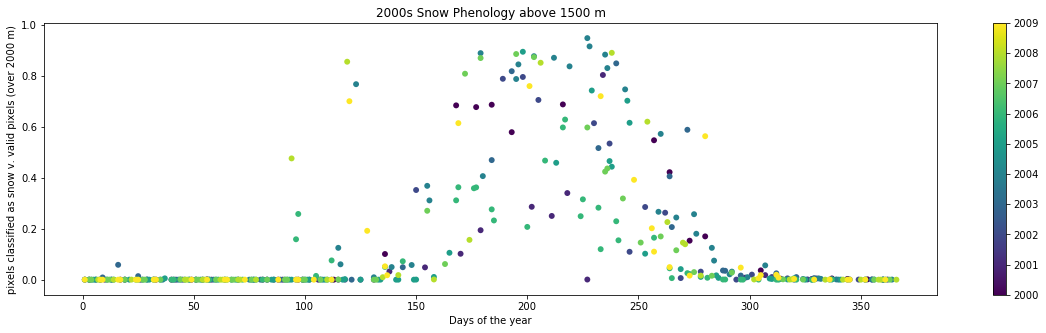

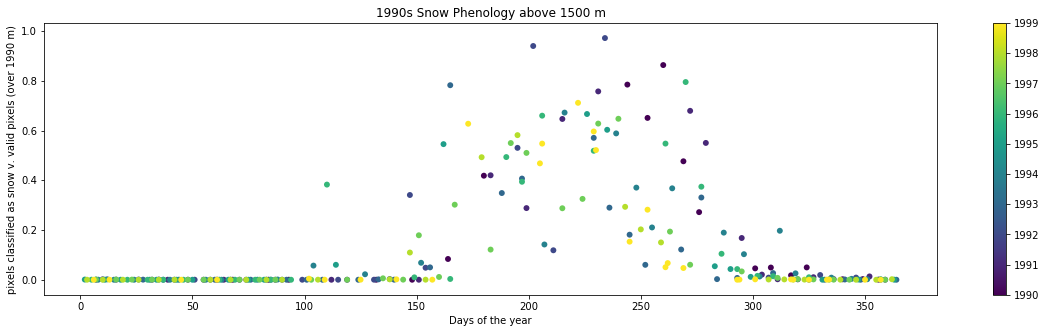

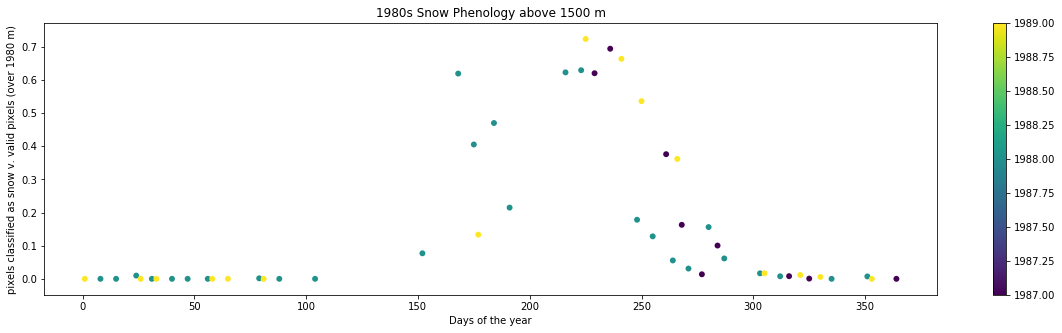

In [25]:
pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW_decades.pdf")

for i, j in snow_phen1500:
    fig, ax = plt.subplots(figsize=(20,5))
#     pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW.pdf")
    sp = ax.scatter(i['dayofyear'], #ndsi_ds.values, 
                    i['snow_prop_elev'], c=i['year'],
                    cmap='viridis', marker='o', edgecolor='none',s=35)
    #plt.ylim(-1, 1)
    plt.title(str(j)+'s Snow Phenology above 1500 m')
    plt.xlabel('Days of the year')
    plt.ylabel('pixels classified as snow v. valid pixels (over '+str(j)+' m)')
    fig.colorbar(sp)
    pdf.savefig()
pdf.close()

In [14]:
# fig, ax = plt.subplots(figsize=(14,5))
# #     pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW.pdf")
# sp = ax.scatter(Snow_phen1800['dayofyear'], #ndsi_ds.values, 
#                 Snow_phen1800['snow_prop_elev'], c=Snow_phen1800['year'],
#                 cmap='jet', marker='o', edgecolor='none',s=35)
# # plt.ylim(-1, 1)
# plt.title('Snow Phenology above 1500 m (1987-2018)')
# plt.xlabel('Days of the year')
# plt.ylabel('ave NDSI for valid pixels over 1500m')
# fig.colorbar(sp)

In [20]:
# fig, ax = plt.subplots(figsize=(14,5))
# #     pdf = matplotlib.backends.backend_pdf.PdfPages("phenology_NSW.pdf")
# sp = ax.scatter(Snow_phen_all['dayofyear'], #ndsi_ds.values, 
#                 Snow_phen_all['average_ndsi'], c=Snow_phen_all['year'],
#                 cmap='jet', marker='o', edgecolor='none',s=35)
# plt.ylim(-1, 1)
# plt.title('Snow Phenology above 1800 m (1987-2018)')
# plt.xlabel('Days of the year')
# plt.ylabel('ave NDSI for valid pixels over 1800m)')
# fig.colorbar(sp)
# pdf.savefig()
# pdf.close()